In [13]:
## load packages

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from helperFxns import lett2num,alg2bin,filterAln,simMat
import pandas as pd
from Bio import SeqIO
import random
import math

In [3]:
## function definitions


def read_fasta(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    seqs = []
    for line in lines:
        if line[0] != '>':
            seqs.append(line.strip())
    return seqs

def one_hot_tranform(seqs,lett2index=None,N_aa=21):
    #convert to numbers
    _num = lett2num(seqs,lett2index=lett2index)
    # convert to one-hot 
    ## dimension M * (N_aa * L)
    seqs_one_hot = alg2bin(_num,N_aa=N_aa).toarray()
    return seqs_one_hot

def calc_cov_mat(seqs_one_hot,N_aa=21):
    # transpose the matrix
    seqs_one_hot_3d = seqs_one_hot.reshape(seqs_one_hot.shape[0],-1,N_aa).transpose(0,2,1)
    # centered the matrix
    seqs_one_hot_3d_centered = seqs_one_hot_3d - np.mean(seqs_one_hot_3d,axis = 0)
    # calculate the covariance matrix
    cov_mat = np.tensordot(seqs_one_hot_3d_centered.T,seqs_one_hot_3d_centered,axes=([2],[0]))/seqs_one_hot_3d_centered.shape[0]
    
    return cov_mat

def fasta_to_dataframe(fasta_file,family_name='A'):
    records = list(SeqIO.parse(fasta_file, "fasta"))
    data = {f"Description_{family_name}": [record.description for record in records],
            f"Sequence_{family_name}": [str(record.seq) for record in records]}
    df = pd.DataFrame(data)
    return df



In [5]:
import re
org_id_pattern = r"organism\s+taxid:\s*\"(\d+(?:_\d+)?)\""

protein_families = ['A','B','C','D']
dfs = []
for fa in protein_families:
    df = fasta_to_dataframe(f"{fa}_filtered.fasta",family_name=fa)
    df['organism_tax_id'] = df[f'Description_{fa}'].str.extract(org_id_pattern, flags=re.IGNORECASE)
    df['gapped_freq'] = df.apply(lambda x: x[f'Sequence_{fa}'].count('-')/len(x[f'Sequence_{fa}']), axis=1)
    df_sorted = df.sort_values(by='gapped_freq', ascending=True)
    df_unique = df_sorted.drop_duplicates(subset='organism_tax_id', keep='first')
    df_unique.reset_index(inplace=True,drop=True)
    dfs.append(df_unique[['organism_tax_id',f'Sequence_{fa}']])

In [6]:
from functools import reduce
df = reduce(lambda x, y: pd.merge(x, y, on='organism_tax_id', how='inner'), dfs)
df['Sequence'] = df.apply(lambda x: ''.join([x[f'Sequence_{fa}'] for fa in protein_families]), axis=1)
df

,organism_tax_id,Sequence_A,Sequence_B,Sequence_C,Sequence_D,Sequence
0,216778_1,ARRYDVFDFAFAHREDAAHHERAVEVWLAPDVPPFHTDAPVTTQVW...,VAVPAKIAPHPDYGDIRIDDFQFGFLDTVDPNLWLNPLARPERALQ...,AADLARRLPTLFAQATAAAA---DPAEGLAAVLASGVVVGDAEVAM...,--LVLGERAAITHVDKDGRGSLNCLVLKDRPLDRAIKIAQAVAHSS...,ARRYDVFDFAFAHREDAAHHERAVEVWLAPDVPPFHTDAPVTTQVW...
1,84531_0,LRLYDLFEFAFENREDAAHAERAVVRWEAADFRPFFADAEVETDVR...,VAVPAKIAPLPDYGEIAIDDYSFGFVDKIEPNLKLKPLARPTRSLQ...,-GDLAQRLPTLFRRAAQAAA---DTTPALEAVLASGVVVGDAERAM...,--FHLGERGAITHVDKDGRGSLNCLVVQDKPMSRALKIAQAIAHSS...,LRLYDLFEFAFENREDAAHAERAVVRWEAADFRPFFADAEVETDVR...
2,69_1,LRVYDVYEFDFENREDARHSERATERWEASDFRPFFADAEVVTDVR...,VAVPAKIAPLPDYGEIAIDEYGFAFLDSVDPNLKLRPLARPERALQ...,HRDLARRLPALFERAAQAAA---SAAEALVAVLASGVVVGEAERAM...,--FHLGERGAITHVDKDGRGSLNCLVVQDKPMSRALKIAQAIAHSS...,LRVYDVYEFDFENREDARHSERATERWEASDFRPFFADAEVVTDVR...
3,69_0,LRVYDVYEFDFENREDARHRERATERWEAPDLRPFFADAAVETDVR...,VAVPAKIAPAPDYGEIAIDDYGFAFLDTVTPDLKLRPLARPARALQ...,AADLAARLPALFDRAAQAAA---SAAEALVAVLASGVVVGEAERAM...,--FHLGERGAITHVDKDGRGSLNCLVVQDKPMSRALKIAQAIAHSS...,LRVYDVYEFDFENREDARHRERATERWEAPDLRPFFADAAVETDVR...
4,701189_0,RRRYDVFDFAFAHRADAPHRERAVPEWEAADIAPFFADAEVEAAVH...,VAVPAKIAPHPDYGEIAIDDFGFAFLDSVAPNLRLKPLPRPARSLQ...,GADLAARLPALFAEARQRAT---DGAEALAAVLASGVVVGDADVAM...,--FVIGERAAITHVDKDGRGSLNCLVLADKPLDRALKIAQAVAHSS...,RRRYDVFDFAFAHRADAPHRERAVPEWEAADIAPFFADAEVEAAVH...
...,...,...,...,...,...,...
2889,141949_0,--------VTRPHTGL--HHHRATGGWGGPPPPPFFGGGGGGTGFP...,VAVPAKIAPWPDYGEIVVDEYRFGFIDRVDPNLKLVPLPRPTRALQ...,TGDLAARLPHLFAGARAAAT---DPSADLAAVLASGVVVGDAHAAM...,--LSLGERAAITHVDKDGRGSLNCLVLADRPLERALKIAQAVAHSS...,--------VTRPHTGL--HHHRATGGWGGPPPPPFFGGGGGGTGFP...
2890,2301224_0,GREFTAFVLNYPNAD--PRSAMKTLRWDSASWEPFVTDG-VVADIL...,VAIPARIAPHCQYGELRFDEYVFDRLRARRNVLHMRPAPYPERSLQ...,NNDMAERVPALYERAADV--AAPSDTKGLREVLASGIVVADASEAA...,--LTMGELEAVTNIDKDGRGSLNVLVIEDKSRGAALKMGYAVAHAS...,GREFTAFVLNYPNAD--PRSAMKTLRWDSASWEPFVTDG-VVADIL...
2891,2340_0,IRRYTIFSYDYPNKE--THPEHQSQKWVTKDLPPFSADG-VETDIK...,IAVPAKIHPHCQYDVVEFDDFSFEFLDKIDPNIRMSPLAFPTRSLQ...,RTQLASSLETVFEGVVRDV--LSAAEAEIRSVIASGVVVADAIEAM...,--LEIGELSAVTHMDKDGRGSLNVLINQEKSMTPALKRAYALAHSS...,IRRYTIFSYDYPNKE--THPEHQSQKWVTKDLPPFSADG-VETDIK...
2892,1818881_0,RRVLNVFAYDYANKE--SHNQRAVEQWEQWDIEPFRVDG-VDADVL...,VAVPAKIHPHPDYDTLEFDEFRFAFIDKVEPNISMGPLAKPERSLQ...,ANDMAQRMNSLLERLAAGI--PQDALAEVRSVLASGVVVADAVQSV...,--IKLGEQAAVTHMDKDGRGSLNVLVIQDRRMTQALKAAYALAHSS...,RRVLNVFAYDYANKE--SHNQRAVEQWEQWDIEPFRVDG-VDADVL...


In [ ]:
## statistical analysis for C and D family
"""
because we can already see some relationship in the heatmap of the concatenated sequences
we decided to use the C and D family as a positive control.
"""




In [7]:
## calculate the covariance matrix for concatenated sequences
seqs = df['Sequence'].to_list()
one_hot = one_hot_tranform(seqs)
cov = calc_cov_mat(one_hot)

In [9]:
## select Frobenius norm as the distance metric
cov_Fro = np.linalg.norm(cov,ord='fro',axis=(1,2))
cov_Fro.shape

(1093, 1093)

In [44]:
def permutation_test(group_A, group_B, n_perm=1e5,random_seed=5232000):
    random.seed(random_seed)
    n_A = len(group_A)
    n_B = len(group_B)
    n = n_A + n_B
    group = np.concatenate([group_A, group_B])
    n_perm = min(int(n_perm),math.perm(n,n_A))
    perm_dist = np.zeros(n_perm)
    observed_diff = np.abs(np.mean(group_A) - np.mean(group_B))
    
    for i in range(n_perm):
        np.random.shuffle(group)
        perm_dist[i] = np.mean(group[:n_A]) - np.mean(group[n_A:])
        
    p_value = np.sum(np.abs(perm_dist) >= np.abs(observed_diff)) / n_perm

    return perm_dist,observed_diff,p_value

In [42]:
len_A = len(df.iloc[0]['Sequence_A'])
len_B = len(df.iloc[0]['Sequence_B'])
len_C = len(df.iloc[0]['Sequence_C'])
len_D = len(df.iloc[0]['Sequence_D'])
A_B_cov = cov_Fro[:len_A,len_A:(len_A+len_B)]
C_D_cov = cov_Fro[(len_A+len_B):(len_A+len_B+len_C),(len_A+len_B+len_C):(len_A+len_B+len_C+len_D)]

In [62]:
perm_dist, observed_diff,p_value = permutation_test(A_B_cov.flatten(),C_D_cov.flatten(),n_perm=1e5)

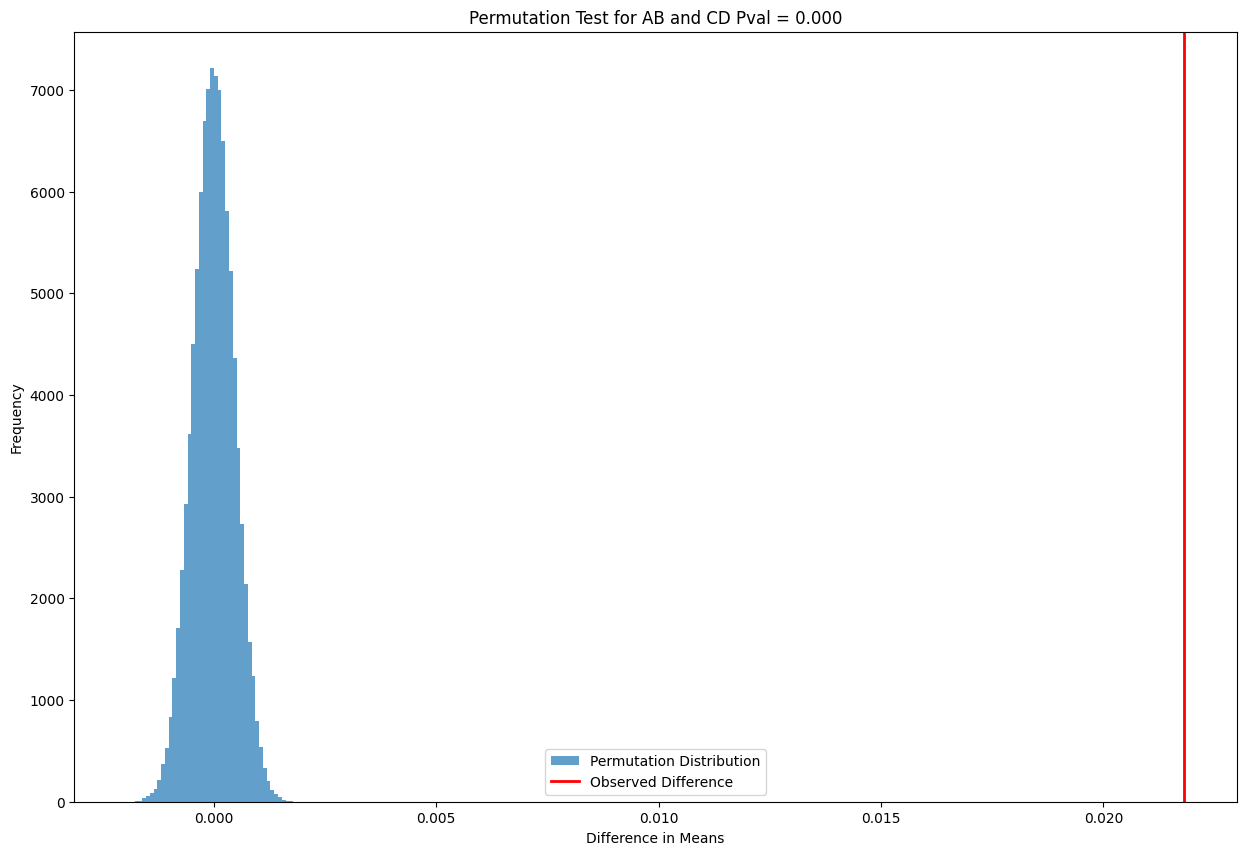

In [64]:
plt.figure(figsize=(15,10))
plt.hist(perm_dist, bins=50, alpha=0.7, label='Permutation Distribution')
plt.axvline(observed_diff, color='red', lw=2, label='Observed Difference')
plt.title(f'Permutation Test for AB and CD Pval = {p_value:.3f}')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [57]:
A_D_cov = cov_Fro[:len_A,(len_A+len_B+len_C):(len_A+len_B+len_C+len_D)]
perm_dist, observed_diff,p_value = permutation_test(A_B_cov.flatten(),A_D_cov.flatten(),n_perm=1e5)

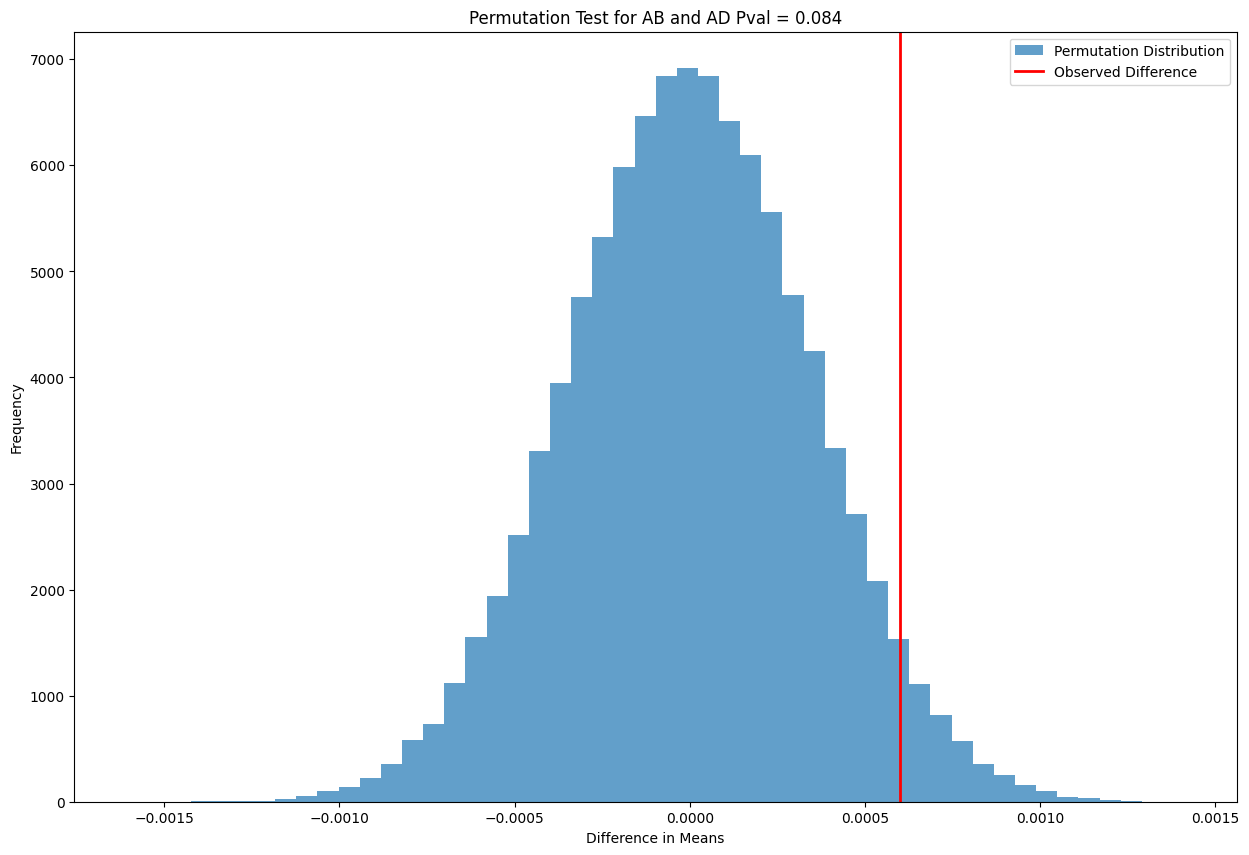

In [61]:
plt.figure(figsize=(15,10))
plt.hist(perm_dist, bins=50, alpha=0.7, label='Permutation Distribution')
plt.axvline(observed_diff, color='red', lw=2, label='Observed Difference')
plt.title(f'Permutation Test for AB and AD Pval = {p_value:.3f}')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [72]:
C_filtered_seqs = read_fasta('C_filtered.fasta')
D_filtered_seqs = read_fasta('D_filtered.fasta')
C_one_hot_3d = one_hot_tranform(C_filtered_seqs).reshape(len(C_filtered_seqs),-1,21)
D_one_hot_3d = one_hot_tranform(D_filtered_seqs).reshape(len(D_filtered_seqs),-1,21)


In [85]:
def generate_pseudo_seqs(seq, n_pseudo=1000,letters='ACDEFGHIKLMNPQRSTVWY-'):
    sequences = []
    for i in range(n_pseudo):
        sequence = ''
        for pos in seq:
            probs = np.random.normal(loc=pos, scale=np.min(pos)/10)
            probs /= np.sum(probs)
            sequence += np.random.choice(list(letters), p=probs)
        sequences.append(sequence)
    return sequences
        
        
        

In [91]:
C_pseudo = generate_pseudo_seqs(np.mean(C_one_hot_3d,axis=0))
D_pseudo = generate_pseudo_seqs(np.mean(D_one_hot_3d,axis=0))
pseudo = [C+D for C,D in zip(C_pseudo,D_pseudo)]

['VNRTAAAMPSVKEALQEL-KQENSGAHEYQDVIASGSIVGDALKAITAAQEPDRIGFGVALPLCNYAKLRAVRETAEE-NARTSGTVGNLSVYYIYGQAYKSVTPIREADATPTTLFILAIGVAQAAKRLEEGEEPPLDVILIGDLGAAACAKYFEELGRIEVPNYYTMLGIPTDANKARIAAVLAFVFTLSQGAKLARLNAGQIVEGDALPDSFPIGLEIADAGAEVMVKMIALSSEPSPDGLTIFPVVAAQNAEPLTQFKQDL-EIWLKLGEIKTVTNMDKDGRGSLCVVLIQEKPMSRARKLAYAVAHSSELAPIIGETACLLVFANLAELDTIARYEVRGTDKLWSHEPGVGPFDLGASVSYSPIIQGDDDAMMPSRMGHLIGVRGAKLAAAHKKTDLGKGAPEVGILAVGKDNIFPHFMGMANSGGGVCATVADP-RNEQAQFQARAELGVIANFDRVLMPFPHPGAATGLLYHADDYNGSWDRVAENVADKLTGTGNDVPIVTAGWLKMRFVNPSQREVDTRGMYVVAKLGLRAAATATAVGHQGAGTEAIIRTKGMRRALLAQGLVNNIKHAGGHNLDERKLYIQAGGVNKTLREAFTLPTPRGQYNALDYALEDIFEPDEQAKVYEAELTNLAPMLIEAVYQGGFQGFLGHADPM-R---',
 'ANVLGARLTRLLARLNGL-VRPQ-ILEAIANVLASGVVAGAGSRIVQAAQSPDRIGFGLLVPPDTYARLKDLLKAVS-VSDGETSTVGPVSLYYTFGSGLRLVQPIREDSSTPAAMFIQAVGN-QAPQNFEEDEEYPVDVVLIGDVGAEKCDQAFAEYGYSHIPNSYGMLGVPIQPYKQRFKRVMKLCIQPSVGHNLARENGGQISPGDAMPDSYPMGLEIVDAGGAPLTKLMKVTYEKNPDGATVYPILAGEQRQALAQLMADLRN--GEKKLMAHVNMLDKDGRGSLNVILTQEKPMEKIRKLAYALAHSSELAPIIGEVRSL

In [92]:
pseudo_one_hot = one_hot_tranform(pseudo)
pseudo_cov = calc_cov_mat(pseudo_one_hot)
pseudo_Fro = np.linalg.norm(pseudo_cov,ord='fro',axis=(1,2))

In [100]:
C_D_pseudo_cov = pseudo_Fro[:len_C,len_C:(len_C+len_D)]

In [104]:
perm_dist, observed_diff,p_value = permutation_test(C_D_cov.flatten(),C_D_pseudo_cov.flatten(),n_perm=1e5)

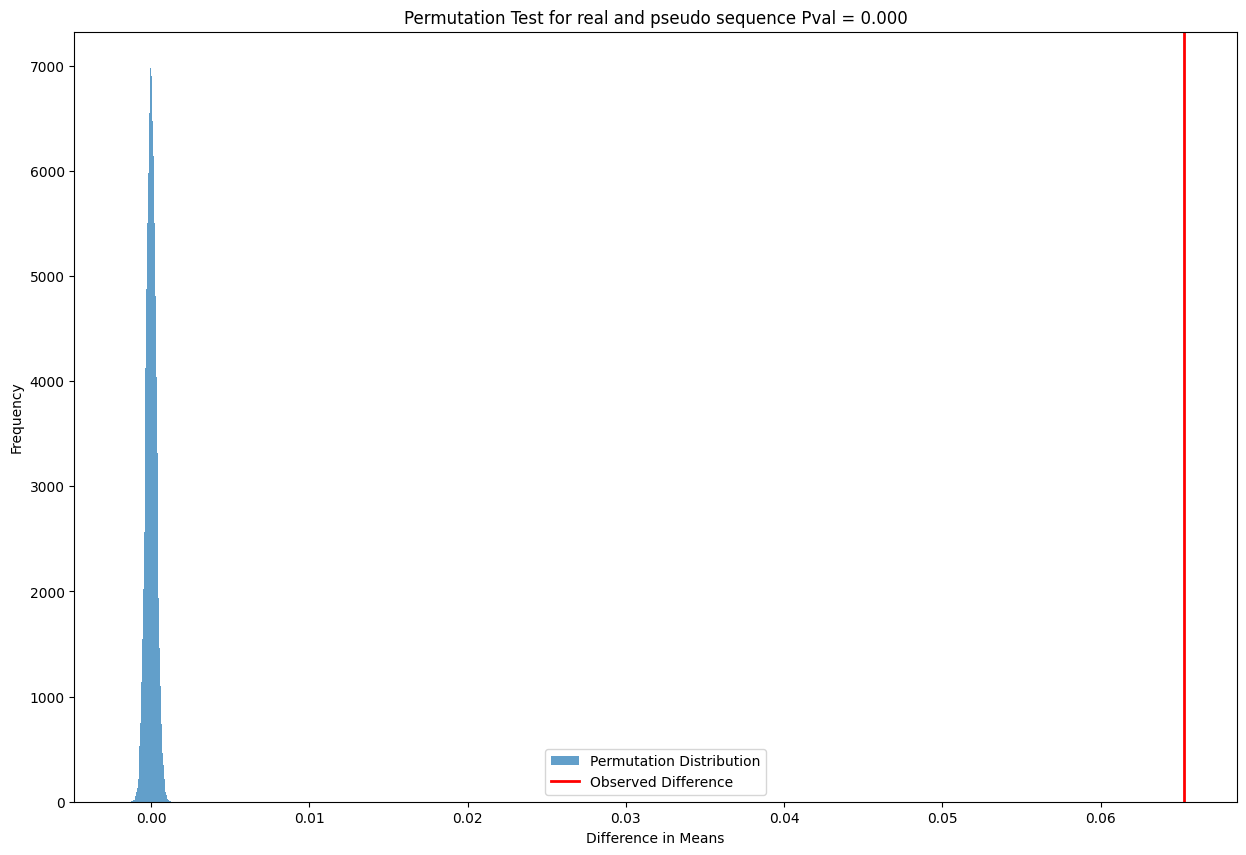

In [105]:
plt.figure(figsize=(15,10))
plt.hist(perm_dist, bins=50, alpha=0.7, label='Permutation Distribution')
plt.axvline(observed_diff, color='red', lw=2, label='Observed Difference')
plt.title(f'Permutation Test for real and pseudo sequence Pval = {p_value:.3f}')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.legend()
plt.show()